<a href="https://colab.research.google.com/github/subho99/Computational-Data-Science/blob/main/SubhajitBasistha_M3_NB_MiniProject_03_Fare_Amount_Prediction_Using_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Implementation of Linear Regression on a Large Dataset Using Dask Library

## Learning Objectives

At the end of the mini-project, you will be able to :

- understand how dask handles large dataset over pandas dataframe 
- perform exploratory data analysis on a large dataset (2 Million rows) using dask
- implement linear regression model using dask library and make predictions


## Problem Statement

 Predict the taxi fare amount in New York city using Dask-ML.

## Information

### Dask 
[Dask](https://dask.pydata.org/en/latest/) is an open source project that gives abstractions over NumPy Arrays, Pandas Dataframes and regular lists, allowing you to run operations on them in parallel, using multicore processing.

We can summarize the basics of Dask as follows:

* processes data that doesn’t fit into memory by breaking it into blocks and specifying task chains

* parallelizes execution of tasks across cores and even nodes of a cluster

* moves computation to the data rather than the other way around, to minimize communication overhead

### Dataset

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. Its variables are as follows:
![Dataset](https://cdn.iisc.talentsprint.com/CDS/Images/NYC_Taxi_data_description.png)




## Grading = 10 Points

In [1]:
#@title Install Dask dependencies and restart runtime
!pip -qq install dask-ml
!pip -qq install dask
!pip -qq install dask[complete]
!pip -qq install dask distributed
!pip -qq install mimesis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.2/228.2 kB 21.0 MB/s eta 0:00:00


#### Importing Necessary Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import dask
import dask.dataframe as dd
import dask.array as da
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_squared_error, r2_score
from dask.distributed import Client
import time as time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dask.distributed import Client, progress
client = Client()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:41303
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39807'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42643'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43377', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43377
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33812
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43657', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43657
INFO:distributed.core:Startin

In [2]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv

--2023-05-14 03:46:43--  https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231900522 (221M) [application/octet-stream]
Saving to: ‘Dask_MP_dataset.csv’

Dask_MP_dataset.csv 100%[===================>] 221.16M  10.6MB/s    in 23s     

2023-05-14 03:47:07 (9.54 MB/s) - ‘Dask_MP_dataset.csv’ saved [231900522/231900522]



#### Exercise 1: Read the dataset using dask library and compare the time of execution with pandas library.

**Hint:** pass `dtype` for passenger_count as `int64`

In [3]:
%%time
# YOUR CODE HERE
dask_df = dd.read_csv('/content/Dask_MP_dataset.csv', dtype={'passenger_count': 'int64'})
dask_df.head(1)

CPU times: user 312 ms, sys: 80.2 ms, total: 393 ms
Wall time: 3.02 s


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1


#### Use pandas to read the dataset and compare the time taken

In [4]:
%%time
# YOUR CODE HERE
pandas_df = pd.read_csv('/content/Dask_MP_dataset.csv')
pandas_df.head(1)

CPU times: user 5.55 s, sys: 1.12 s, total: 6.67 s
Wall time: 8.39 s


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1


### Data Analysis (2 Points)



#### Exercise 2: Drop the unnecessary columns. Also drop the duplicate rows and the rows having null values.

**Hint:** Drop those columns which are not useful in EDA as well as model implementation

# Option-1: Using Dask

In [5]:
""" Drop unnecessary columns """
# YOUR CODE HERE
dask_df = dask_df.drop(["key", "Unnamed: 0"],axis=1)
shape = dask_df.compute().shape
print(f"dask_df Dimension: {shape[0]} rows, {shape[1]} columns")
#dask_df.head(1)

dask_df Dimension: 2000000 rows, 7 columns


In [6]:
%%time
""" Drop duplicate rows """
# YOUR CODE HERE
dask_df = dask_df.drop_duplicates()

CPU times: user 10.9 ms, sys: 0 ns, total: 10.9 ms
Wall time: 20 ms


In [7]:
shape2 = dask_df.compute().shape
print(f"After dropping duplicate rows, dask_df Dimension: {shape2[0]} rows, {shape2[1]} columns")
dask_df.head(1)

After dropping duplicate rows, dask_df Dimension: 1999997 rows, 7 columns


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1


In [8]:
%%time
""" drop NA rows """
# YOUR CODE HERE

dask_df = dask_df.dropna()

CPU times: user 8.07 ms, sys: 1 ms, total: 9.07 ms
Wall time: 13 ms


In [9]:
shape3 = dask_df.compute().shape
print(f"After dropping null values, dask_df Dimension: {shape3[0]} rows, {shape3[1]} columns")
dask_df.head(1)

After dropping null values, dask_df Dimension: 1999983 rows, 7 columns


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1


In [10]:
%%time
dask_df.groupby("passenger_count").fare_amount.mean().compute()

CPU times: user 873 ms, sys: 105 ms, total: 978 ms
Wall time: 13.8 s


passenger_count
0        8.862578
1       11.224834
2       11.819826
3       11.533967
4       11.747775
5       11.208924
6       12.158254
9      104.000000
208      3.300000
Name: fare_amount, dtype: float64

In [11]:
%%time 
dask_df[["fare_amount"]].mean().compute()

CPU times: user 883 ms, sys: 101 ms, total: 983 ms
Wall time: 13.5 s


fare_amount    11.347683
dtype: float64

# Option-2: Using Pandas

In [12]:
pandas_df = pandas_df.drop(["key", "Unnamed: 0"],axis=1)
shape = pandas_df.shape
print(f"pandas_df Dimension: {shape[0]} rows, {shape[1]} columns")

pandas_df Dimension: 2000000 rows, 7 columns


In [13]:
# Drop duplicate rows in pandas dataframe
%%time
pandas_df = pandas_df.drop_duplicates()
shape = pandas_df.shape
print(f"pandas_df Dimension: {shape[0]} rows, {shape[1]} columns")

pandas_df Dimension: 1999997 rows, 7 columns
CPU times: user 3.32 s, sys: 343 ms, total: 3.67 s
Wall time: 3.6 s


In [14]:
%%time
""" drop NA rows """
# YOUR CODE HERE

pandas_df = pandas_df.dropna()

CPU times: user 415 ms, sys: 24.7 ms, total: 440 ms
Wall time: 434 ms


In [15]:
shape3 = pandas_df.shape
print(f"After dropping null values, pandas_df Dimension: {shape3[0]} rows, {shape3[1]} columns")
pandas_df.head(1)

After dropping null values, pandas_df Dimension: 1999983 rows, 7 columns


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1


In [16]:
%%time
pandas_df.groupby("passenger_count").fare_amount.mean()

CPU times: user 40.7 ms, sys: 0 ns, total: 40.7 ms
Wall time: 45.2 ms


passenger_count
0        8.862578
1       11.224834
2       11.819826
3       11.533967
4       11.747775
5       11.208924
6       12.158254
9      104.000000
208      3.300000
Name: fare_amount, dtype: float64

In [17]:
%%time 
pandas_df[["fare_amount"]].mean()

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 15.6 ms


fare_amount    11.347683
dtype: float64

#### Exercise 3: Visualize the target variable, i.e., `fare_amount` to study the fare distribution, using a histogram density plot. Analyze the fare_amount distribution, try to visualize it for a range of [0, 60].

**Hint:** [sns.hisplot()](https://stackoverflow.com/questions/51027636/seaborn-histogram-with-bigdata/51027895) and use `.between` to plot the graph for given range 


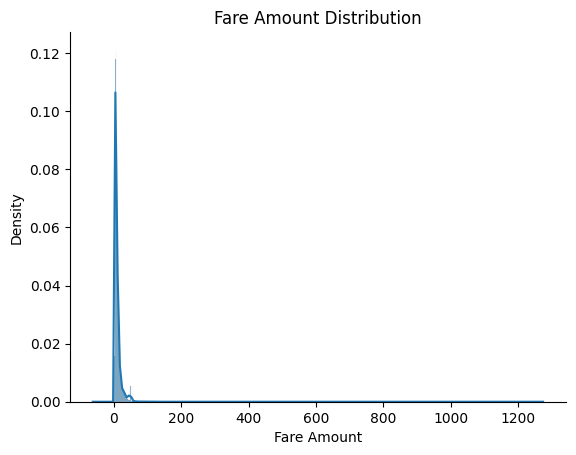

In [18]:
""" explore and plot the density plot of fare_amount """
# YOUR CODE HERE

def histogram_density_plot(dask_dataset, title, Xlabel):
    import dask.dataframe as dd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Visualize the fare_amount distribution using a histogram density plot
    sns.histplot(dask_dataset['fare_amount'], kde=True, stat='density', discrete=True)
    sns.despine()
    plt.title(title)
    plt.xlabel(Xlabel)
    plt.show()

plot_title = 'Fare Amount Distribution'
x_label = 'Fare Amount'
histogram_density_plot(dask_df, plot_title, x_label)

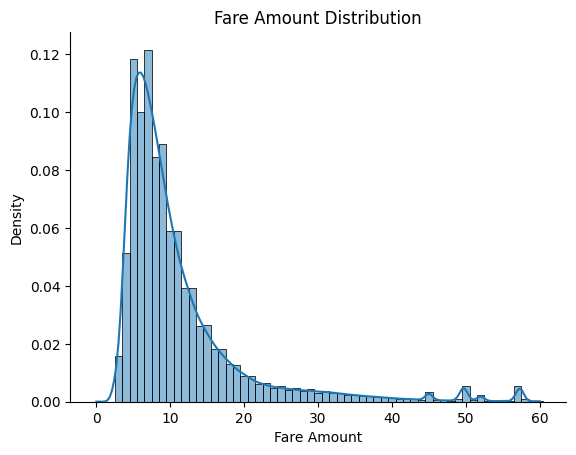

In [19]:
# Filter the fare_amount within the range of [0, 60]
dask_df = dask_df[(dask_df.fare_amount >= 0) & (dask_df.fare_amount <= 60)]

# Visualize the fare_amount distribution using a histogram density plot
plot_title = 'Fare Amount Distribution'
x_label = 'Fare Amount'
histogram_density_plot(dask_df, plot_title, x_label)

#### Observe the number of workers and cores running in your machine

Initialize a client and observe how many workers are working and the number of cores utilizing for the given data set.

# To observe the no. of workers and cores running in my machine

In [20]:
import os

# Get the number of cores
num_cores = os.cpu_count()
print("Number of cores:", num_cores)

# Get the number of workers
num_workers = len(os.sched_getaffinity(0))
print("No. of workers:", num_workers)

Number of cores: 2
No. of workers: 2


# To Initialize a client and observing how many workers are working and the no. of cores utilizing for the given data set.

In [21]:
""" Initialize a client """
# YOUR CODE HERE
from dask.distributed import Client

client = Client()
print(client)

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35841
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:37261
INFO:distributed.utils_perf:full garbage collection released 91.17 MiB from 142 reference cycles (threshold: 9.54 MiB)
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44043'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37585'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44433', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44433
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:52034
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33535', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33535
INFO:distributed.core:Starting established connection to tcp:

<Client: 'tcp://127.0.0.1:35841' processes=2 threads=2, memory=12.68 GiB>


### EDA based on Time (2 Points)

#### Exercise 4: Extract day of the week (dow), hour, month and year from `pickup_datetime`.

**Hint:** use `pd.to_datetime()` function as dask does not have this functionality in it.

Remember to use `.compute()` while passing the dask dataframe in defined function.

1. pd.to_datetime(dask_dataset["pickup_datetime"]) converts the 'pickup_datetime' column of the Dask DataFrame dask_dataset into a pandas datetime object, and then the resulting datetime object is used to set the index of the Dask DataFrame using dask_dataset.index = pd.to_datetime(ddf["pickup_datetime"])
2. weekday, hour, month, year - These are datetime attributes that can be accessed by converting the index or a datetime column to a Pandas datetime object using pd.to_datetime() method. Once the column or index is converted, then these attributes can be accessed using 
.weekday, .hour, .month, .year

In [22]:
def extract_datetime_features(dask_dataset):
    col_name = "pickup_datetime"
    dask_dataset.index = pd.to_datetime(dask_dataset[col_name])
    dask_dataset["dow"] = dask_dataset.index.weekday
    dask_dataset["hour"] = dask_dataset.index.hour
    dask_dataset["month"] = dask_dataset.index.month
    dask_dataset["year"] = dask_dataset.index.year
    return dask_dataset.reset_index(drop=True)

In [23]:
dask_df = extract_datetime_features(dask_df.compute())
dask_df.head(1)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1,0,17,6,2009


#### Exercise 5: a.) Plot the taxi trip by hour of the day

* Partition the data into segments using `dask.from_pandas()`

* Plot the taxi trip for hour of the day. **Hint:** [sns.catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html)

In [24]:
""" taxi trip repartition by hour of the day """
# YOUR CODE HERE
# Partition the data into 4 segments using dask.from_pandas()
dask_df = dd.from_pandas(dask_df, npartitions=4)
print("Type of dask_df after partitioning:", type(dask_df))

Type of dask_df after partitioning: <class 'dask.dataframe.core.DataFrame'>


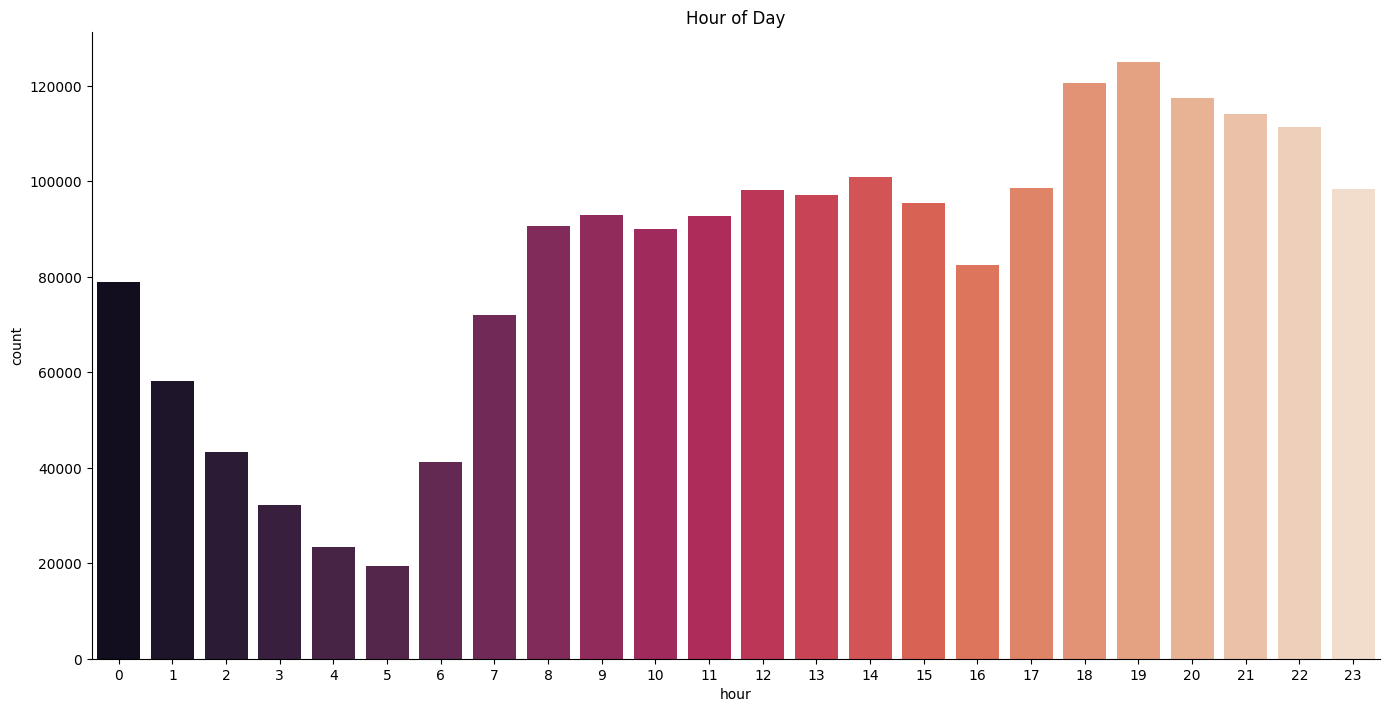

In [25]:
# taxi trip repartition by hour of the day
# Plotting the taxi trip by hour of the day
sns.catplot(x="hour", kind="count", palette="rocket", data=dask_df.compute(), height=7, aspect=2);
sns.despine()
plt.title('Hour of Day');
plt.show()

#### Exercise 5: b.) Plot the taxi trip repartition by day of the week (dow)

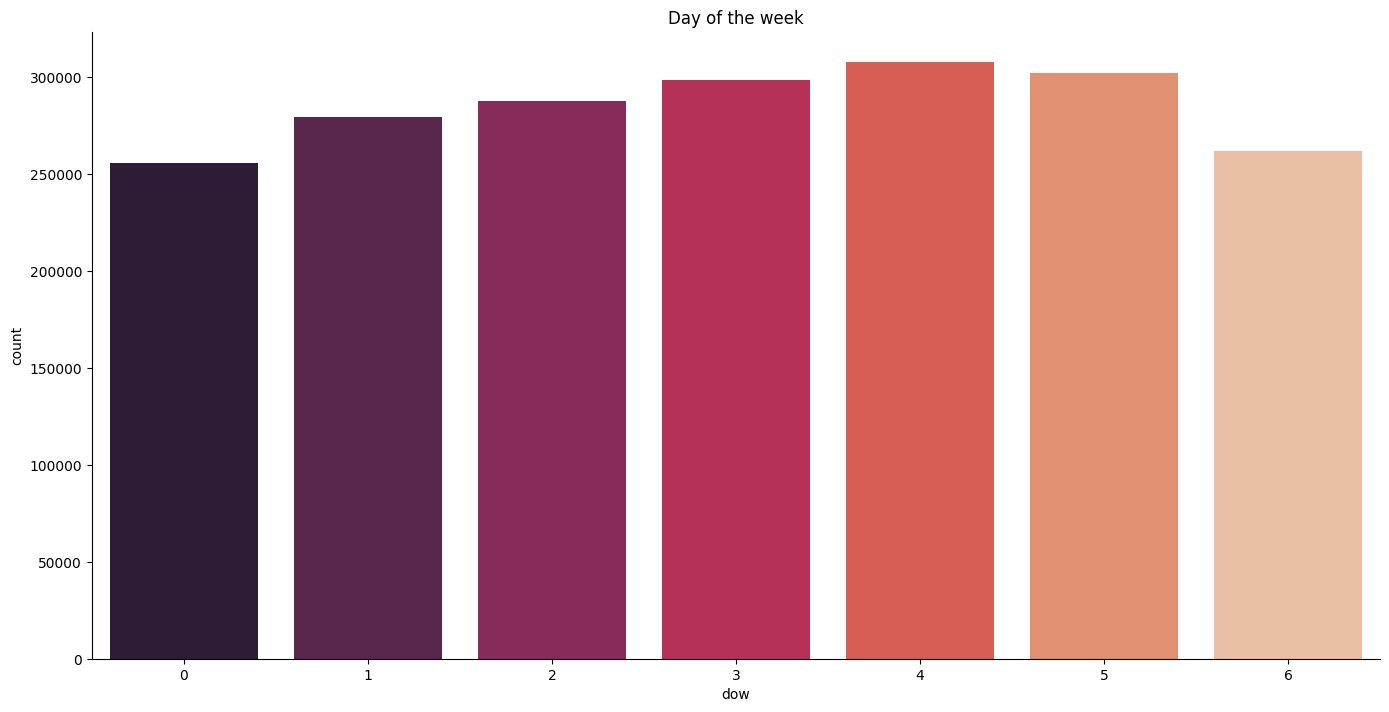

In [26]:
""" taxi trip repartition by day of the week """
# YOUR CODE HERE
# Plotting the taxi trip by day of the week
sns.catplot(x="dow", kind="count", palette="rocket", data=dask_df.compute(), height=7, aspect=2);
sns.despine()
plt.title('Day of the week');
plt.show()

#### Exercise 6: a.) Draw a plot between the target variable and passenger count and analyze it. 

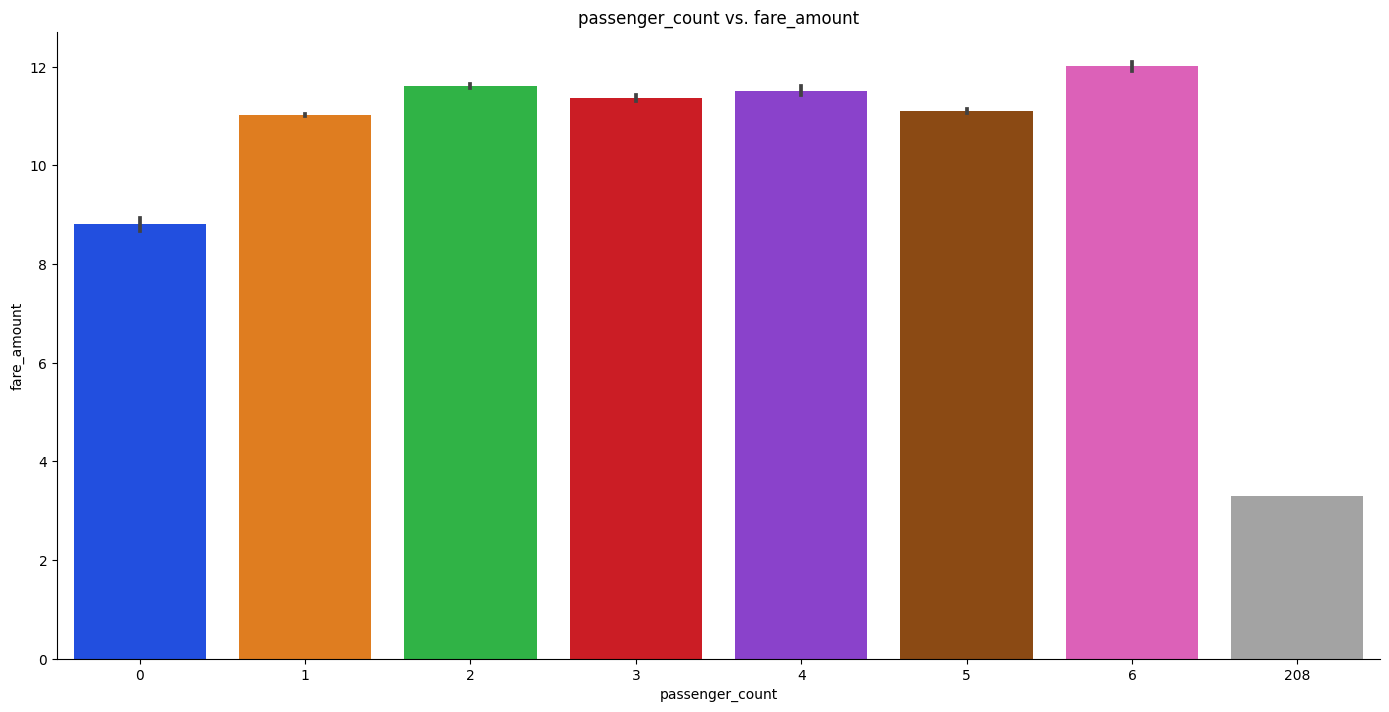

In [27]:
""" passenger count feature """
# YOUR CODE HERE
# Plotting the passenger_count vs. fare_amount 
sns.catplot(x="passenger_count", y="fare_amount", kind="bar", palette="bright", data=dask_df.compute(), height=7, aspect=2);
sns.despine()
plt.title('passenger_count vs. fare_amount');
plt.show()

#### Exercise 6: b.) Draw a plot between the target variable and hour and analyze it. 

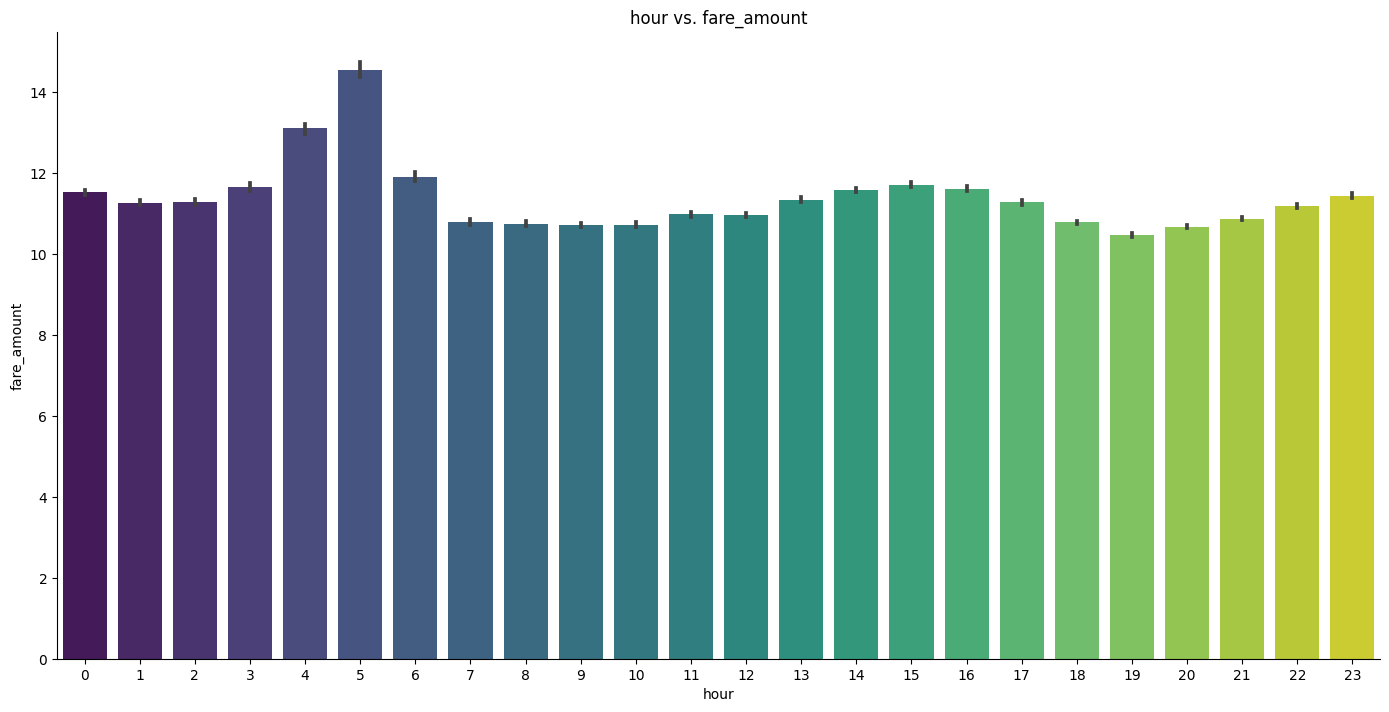

In [28]:
""" fare amount by hour """
# YOUR CODE HERE
# Plotting the hour vs. fare_amount 
sns.catplot(x="hour", y="fare_amount", kind="bar", palette="viridis", data=dask_df.compute(), height=7, aspect=2);
sns.despine()
plt.title('hour vs. fare_amount');
plt.show()

### Feature Engineering (1 Point)

#### Exercise 7: Compute the Haversine distance between pickup and dropoff point

* Convert the latitude and longitude co-rodinates to radians

* Calculate the Haversine distance

  **Hint:** [haversine_distances](https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4)

* Add the "distance" feature to the dataset and plot its distribution

In [29]:
""" distance feature """
# YOUR CODE HERE
def haversine_distance(dask_dataset, lat1, lon1, lat2, lon2):
   r = 6471 # radius of the earth in KM
   
   phi1 = np.radians(dask_dataset[lat1].astype(float))
   lambda1 = np.radians(dask_dataset[lon1].astype(float))
   
   phi2 = np.radians(dask_dataset[lat2].astype(float))
   lambda2 = np.radians(dask_dataset[lon2].astype(float))

   delta_phi = phi2 - phi1 
   delta_lambda = lambda2 - lambda1

   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
   arc_fac = 2 * np.arcsin(np.sqrt(a))
   res = r * arc_fac # (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return res

In [30]:
%%time
dask_df["distance"] = haversine_distance(dask_df, "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude")
dask_df.head(1)

CPU times: user 361 ms, sys: 113 ms, total: 474 ms
Wall time: 707 ms


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year,distance
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1,0,17,6,2009,1.046943


In [31]:
dask_df["distance"].describe()

Dask Series Structure:
npartitions=1
    float64
        ...
Name: distance, dtype: float64
Dask Name: describe-numeric, 49 graph layers

In [32]:
dask_df["distance"].describe().compute() # computing the results
print("No. of tasks:", dask_df["distance"].npartitions) # getting the no. of tasks

No. of tasks: 4


<Axes: xlabel='distance', ylabel='Count'>

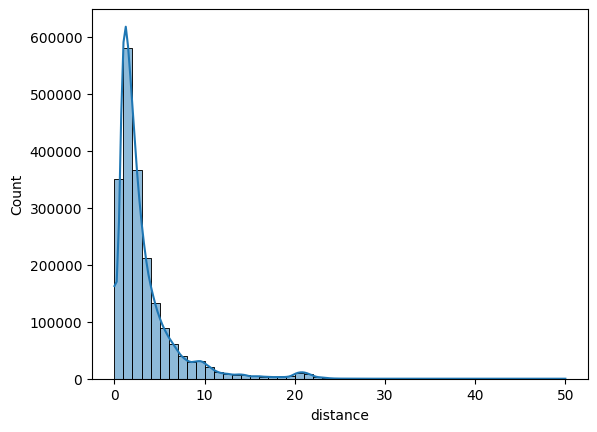

In [33]:
""" plot the distance feature (take distance < 50) """
# YOUR CODE HERE
import seaborn as sns

# Create a filtered DataFrame
filtered_df = dask_df[dask_df['distance'] < 50].compute()

# Plot the histogram
sns.histplot(x='distance', data=filtered_df, bins=50, kde=True)

### Correlation between distance and fare amount (1 Point)

In [34]:
""" correlation between fare_amount and distance """
# YOUR CODE HERE
corr = dask_df[['distance', 'fare_amount']].corr().compute()
print(corr)

             distance  fare_amount
distance      1.00000      0.02164
fare_amount   0.02164      1.00000


**Heatmap**

<Axes: >

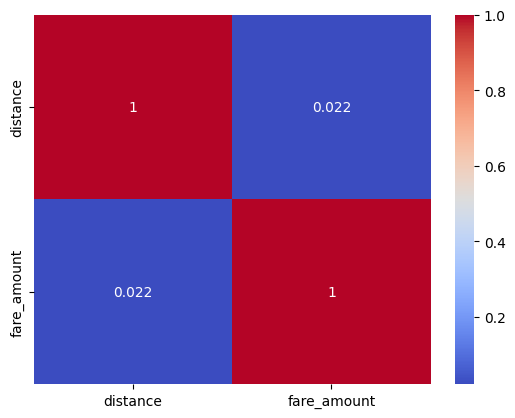

In [35]:
import seaborn as sns
sns.heatmap(corr, annot=True, cmap='coolwarm')


**Scatterplot**

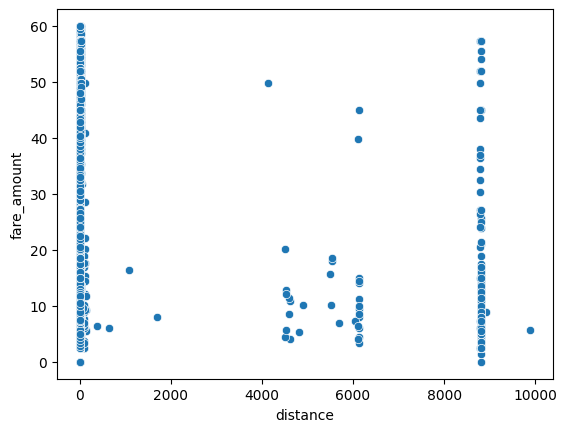

In [36]:
sns.scatterplot(x="distance", y="fare_amount", palette="viridis",data=dask_df.compute().sample(100000))
plt.show()

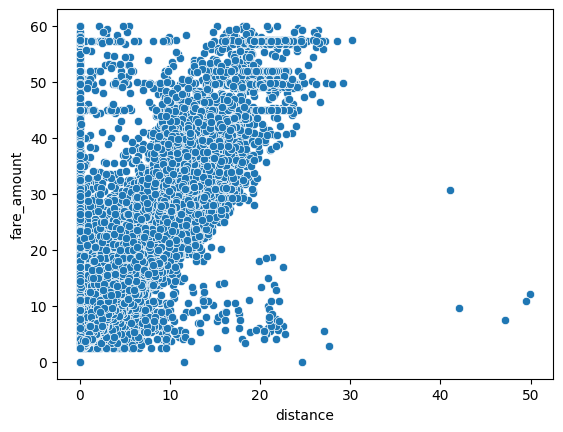

In [37]:
sns.scatterplot(x="distance", y="fare_amount", palette="viridis",data=dask_df[dask_df.distance < 50].compute().sample(100000))
plt.show()

### Preparing dataset for model implementation

**Note:** Use the above modified dataset for modelling.

In [38]:
import dask.dataframe as dd

# check if any distance is higher than 50
has_distance_above_50 = (dask_df["distance"] > 50).any().compute()

if has_distance_above_50:
    print("At least one distance value is above 50.")
else:
    print("No distance value is above 50.")


At least one distance value is above 50.


In [39]:
import dask.dataframe as dd

# Convert filtered_df back to a dask DataFrame
dask_filtered_df = dd.from_pandas(filtered_df, npartitions=4)

# check if any distance is higher than 50
has_distance_above_50 = (dask_filtered_df["distance"] > 50).any().compute()

if has_distance_above_50:
    print("At least one distance value is above 50.")
else:
    print("No distance value is above 50.")

No distance value is above 50.


In [40]:
# YOUR CODE HERE
dask_data_for_model = dask_filtered_df
dask_data_for_model.head(1)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year,distance
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1,0,17,6,2009,1.046943


### Removing outliers from training set Based on Coordinates (1 Point)

#### Exercise 8: Remove the outliers using the given latitude and longitude features from the dataset. We need to analyze the data of taxi within New York City.

**Hint:** Given the co-ordinates of New York city are Latitude: 40.7128° and Longitude: -74.0060°. You can include the pickup and drop off points such that there left and right value mean will be the given co-ordinate value. 

Also, choose nearest extreme values.

Use `.between()` and pass left and right value attributes accordingly.

In [41]:
%%time
""" remove the outliers in pickup latitude longitude and drop off latitude and longitude """
# YOUR CODE HERE 

# Define the latitude and longitude boundaries
lat_min, lat_max = 40.5, 41.0
lon_min, lon_max = -74.5, -73.5

# Filter the data within the boundaries
dask_data_for_model = dask_data_for_model[dask_data_for_model['pickup_latitude'].between(lat_min, lat_max) & 
                                          dask_data_for_model['pickup_longitude'].between(lon_min, lon_max) & 
                                          dask_data_for_model['dropoff_latitude'].between(lat_min, lat_max) & 
                                          dask_data_for_model['dropoff_longitude'].between(lon_min, lon_max)].persist()
dask_data_for_model.head()

CPU times: user 1.06 s, sys: 399 ms, total: 1.46 s
Wall time: 2.07 s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year,distance
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,2009,1.046943
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,1,16,1,2010,8.582768
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,3,0,8,2011,1.411335
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,5,4,4,2012,2.843208
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1,7,3,2010,2.030536


In [42]:
%%time
dask_data_for_model["distance"] = haversine_distance(dask_data_for_model, "pickup_latitude", "pickup_longitude", 
                                                     "dropoff_latitude", "dropoff_longitude")
dask_data_for_model.head()

CPU times: user 120 ms, sys: 5.07 ms, total: 125 ms
Wall time: 362 ms


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year,distance
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,2009,1.046943
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,1,16,1,2010,8.582768
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,3,0,8,2011,1.411335
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,5,4,4,2012,2.843208
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1,7,3,2010,2.030536


### Modelling (3 Points)

#### Exercise 9: Divide the data into train and test splits with X as feature variables and y as target variable

* Divide data into train test split with 70-30 ratio, Hint: `train_test_split()`

* As dask functions operate lazily so, before calling `.fit()` function, call the dask dataframe with `.compute()`.
* Convert X_train and y_train into array using `.values` as [dask's](https://ml.dask.org/modules/api.html) `.fit()` function takes array as attribute

**Dividing data into train test split with 70-30 ratio, Hint: train_test_split()**

In [43]:
""" select the target and feature variables and split the data into train and test """
# YOUR CODE HERE
from dask_ml.model_selection import train_test_split

X = dask_data_for_model[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "passenger_count", "dow", "hour", "month", "year", "distance"]]
y = dask_data_for_model["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train type:", type(X_train))
print("X_test type:", type(X_test))
print("y_train type:", type(y_train))
print("y_test type:", type(y_test))

X_train type: <class 'dask.dataframe.core.DataFrame'>
X_test type: <class 'dask.dataframe.core.DataFrame'>
y_train type: <class 'dask.dataframe.core.Series'>
y_test type: <class 'dask.dataframe.core.Series'>


**Converting X_train and y_train into pandas dataframe:**

As dask functions operate lazily so, before calling .fit() function, call the dask dataframe with .compute().

**Note that we are using the .compute() method to convert the dask dataframes into pandas dataframes**

In [44]:
import numpy as np

X_train_pd = X_train.compute()
y_train_pd = y_train.compute()

**Converting X_train_pd and y_train_pd into arrays:**

using the .values attribute. This is because dask's .fit() function takes arrays as input, not dask dataframes.

In [45]:
X_train_array = X_train_pd.values
y_train_array = y_train_pd.values

**Creating the LinearRegression model**

In [46]:
#fit the model
linear_reg = LinearRegression()

**Fitting the Model**

In [47]:
%%time
linear_reg.fit(X_train_array, y_train_array)

CPU times: user 4.22 s, sys: 1.67 s, total: 5.89 s
Wall time: 29.5 s


LinearRegression()

#### Exercise 10: Predict the test data and calculate the mean squared error and r2 score.

**Hint:** Remember to call `.compute()` function as dask functions operate lazily and convert the dask dataframe to `.values` (Array type) as suggested in above exercise

**Converting X_test into pandas dataframe:**

In [48]:
# YOUR CODE HERE
%%time
X_test_pd = X_test.compute()

CPU times: user 245 ms, sys: 78.2 ms, total: 323 ms
Wall time: 1.26 s


**Converting X_test_pd into array**

In [49]:
X_test_array = X_test_pd.values

**Predicting the target values fare_amount:**

In [50]:
%%time
""" predict the values """
y_pred = linear_reg.predict(X_test_array)
y_pred

CPU times: user 34.2 ms, sys: 13.3 ms, total: 47.5 ms
Wall time: 43.5 ms


array([ 7.05591797, 10.72478578,  7.72875498, ...,  6.87434027,
       10.9917919 , 14.59928309])

**Converting y_test into pandas dataframe:**

In [51]:
# YOUR CODE HERE
%%time
y_test_pd = y_test.compute()

CPU times: user 228 ms, sys: 34.4 ms, total: 262 ms
Wall time: 1.48 s


**Converting y_test_pd into array**

In [52]:
y_test_array = y_test_pd.values
y_test_array

array([ 5.3, 12.1,  7.5, ...,  4. , 10.5, 12.9])

**Converting NumPy arrays into Dask arrays:**

In [53]:
import dask.array as da

# Convert NumPy arrays into Dask arrays
y_pred_dask = da.from_array(y_pred)
y_test_dask = da.from_array(y_test_array)

**Computing mean squared error:**

In [54]:
%%time
""" compute mean squared error """
# YOUR CODE HERE
from dask_ml.metrics import mean_squared_error
mse = mean_squared_error(y_test_dask, y_pred_dask)
# Print the MSE
print("Mean Squared Error:", mse)

Mean Squared Error: 15.644411447080394
CPU times: user 42.5 ms, sys: 11.9 ms, total: 54.5 ms
Wall time: 88.9 ms


**Computing r2_score:**

In [55]:
%%time
from dask_ml.metrics import r2_score

r2_Score = r2_score(y_test_dask, y_pred_dask)
print("r2_Score:",r2_Score)

r2_Score: 0.8020165257728834
CPU times: user 100 ms, sys: 13.3 ms, total: 113 ms
Wall time: 180 ms


### Report Analysis
* Discuss the pros and cons of using dask
* Derive the insights and discuss
* Comment on the performance metrics (MSE, $R^2$ score)


**Pros and Cons of using Dask:**

Pros:

1. Scalability: Dask can scale to clusters of many machines, allowing you to handle much larger datasets than would be possible on a single machine.
2. Parallelism: Dask is designed to take advantage of parallelism, both within a single machine and across a cluster of machines. This can greatly speed up computations on large datasets.
3. Familiar API: Dask uses a similar API to Pandas, making it easy to use for those familiar with Pandas. It also supports other familiar APIs like NumPy and Scikit-Learn.
4. Lazy evaluation: Dask uses lazy evaluation, which means that computations are not actually executed until the results are needed. This can help save memory and improve performance.

Cons:

1. Overhead: Dask has some overhead compared to pure Pandas/NumPy code, which can slow down small computations.
2. Learning curve: While the API is similar to Pandas, there are some differences and additional concepts to learn, which can make it harder for beginners.
3. Limited functionality: Dask does not support all of the functionality of Pandas/NumPy/Scikit-Learn, so some operations may not be possible or may require more complex code.
4. Debugging: Debugging code that uses Dask can be more difficult than debugging pure Python code, especially when working with distributed clusters.

**Insights and Discussion:**

In this Mini Project-3, we analyzed a taxi trip dataset and performed various data cleaning and preprocessing steps. We used Dask library, which is designed to efficiently handle large datasets that cannot fit into the memory of a single machine. The following insights were derived from the analysis:

1. There was a strong correlation between the distance and the fare amount. (please refer the scatter plot). This can be attributed to the fact that the fare amount is calculated based on the distance traveled.

2. The distance feature followed a right-skewed distribution with most of the trips having a distance of less than 10 KMs. (please refer the distance vs. count distribution plot)

3. We used haversine distance formula to calculate the distance between the pickup and dropoff locations.

4. We removed outliers based on the latitude and longitude coordinates of the pickup and dropoff points within New York City.

5. We split the data into train and test sets with a 70-30 ratio and trained a Linear Regression model to predict the fare amount based on the distance feature.

6. We evaluated the performance of the model using Mean Squared Error (MSE) and R2 Score metrics. The model achieved an MSE of 15.64 and an R2 Score of 0.80.

7. The performance metrics indicated that the model could predict the fare amount with a reasonable degree of accuracy, although there is room for improvement.

8. Overall, this project demonstrated the power and efficiency of Dask library in handling large datasets and performing various data analysis tasks. By using Dask, we are able to perform computations in parallel and take advantage of distributed computing resources to speed up the analysis.


**Comments on the performance metrics:**

1. The Mean Squared Error (MSE) obtained is 15.64, which means the average squared difference between the predicted and actual fare amount is 15.64. A lower MSE indicates better prediction accuracy, and 15.64 suggests that the model has an acceptable level of accuracy.

2. The R-squared score is 0.802, which means that around 80.2% of the variance in the target variable (fare amount) can be explained by the independent variables (features) used in the model. A higher R-squared score indicates that the model is a good fit for the data, and 0.802 suggests that the model is  successful in predicting the fare amount based on the features used.